In [186]:
import numpy as np
import matplotlib.pyplot as plt
from solve_hand_to_mouth import *
from copy import deepcopy
from estimation import *

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_new = deepcopy(model)
model.par.model = 'HTM'
model_new.par.model = 'HTM'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [187]:
model.par.eta = 1  # Reference dependence
model.par.types = 1  # No heterogeneity
model.allocate()

est_par = ['delta', 'gamma', 'lambdaa', 'N', 'cost1'] # Parameters to estimate
theta0 = [0.95, 0.1, 1.0, 10, 100.0]  # Initial guesses
bounds = [(0.5, 1), (0.001, 10.0), (0.0, 10.0), (0,50), (0.0,500)] # Bounds for the parameters

# est = method_simulated_moments(model, est_par,theta0,bounds,weight=False)

model.par.noOfParams = len(est_par)
model.par.noSearchInits = 10


for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(0.7, 0.99),
              np.random.uniform(model.par.lb_gam,model.par.ub_gam),
              np.random.uniform(model.par.lb_sig,model.par.ub_sig),
              np.random.uniform(model.par.lb_N,model.par.ub_N),
              np.random.uniform(model.par.lb_lsc,500)]

    est_best = np.inf
    est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)

    if est.fun < est_best:
        est_best = est.fun
        par = est.x
        nit = est.nit



print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

Optimization Results:
---------------------
Parameter       Estimate       
delta                     0.852
gamma                     0.964
lambdaa                   4.812
N                        14.867
cost1                   478.756
Objective:               0.2740
Number of iterations:    27


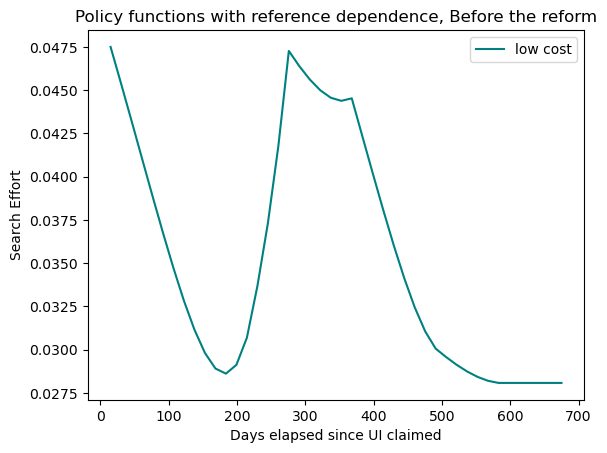

In [188]:
search_effort = solve_search_effort_HTM(model.par)
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort[0,:], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort[1,:], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions with reference dependence, Before the reform')
plt.legend()
plt.show()

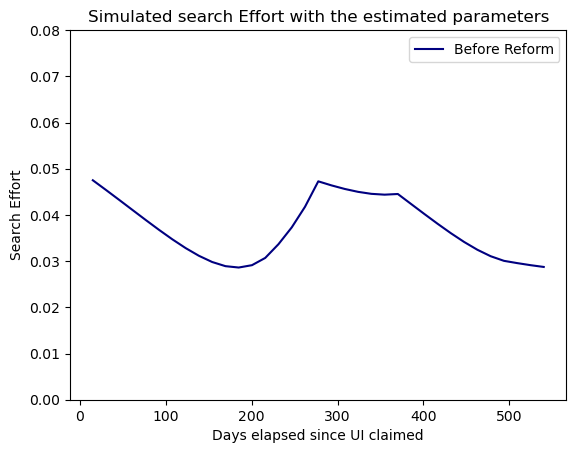

In [189]:
sim = sim_search_effort_HTM(model.par)
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim, color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

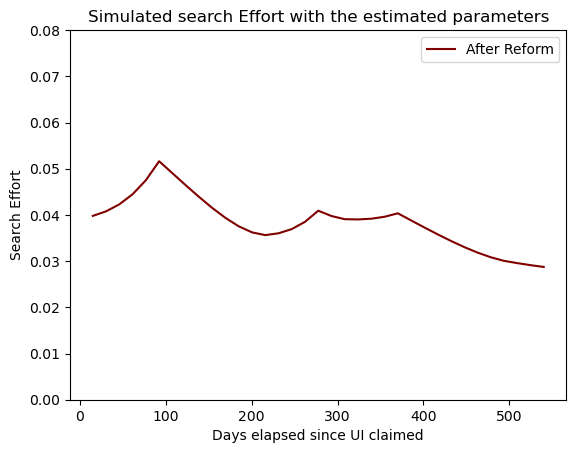

In [190]:
model.par.b1 = 342.0/675.0      # Value after reform
model.par.b2 = 171.0/675.0      # Value after reform

model.allocate()
s_forecast = model.solve()

true_data_outofsample = model.data.moments_after
true_data_insample = model.data.moments_before
mse_eta1_outofsample = np.mean((true_data_outofsample - s_forecast)**2)
mse_eta1_insample = np.mean((true_data_insample - sim)**2)

# Now plotting s_forecast
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, s_forecast, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

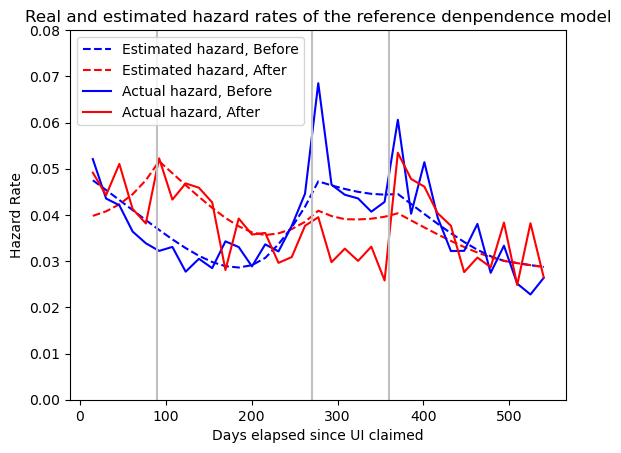

In [191]:
#Replicating figure 7(b) from the paper
after = model_new.data.moments_after
before = model_new.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [245]:


model_new.par.eta = 0.0     # Removes reference dependence
model_new.par.types = 3    # Allow for heterogeneity
# model_new.par.full_sample_estimation = True
model_new.allocate()

est_par = ['delta','gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3'] # Parameters to estimate
theta0 = [0.9, 0.9, 84, 242, 310, 0.4, 0] # Initial guesses
bounds = [(0.5,1.0), (0, 50.0), (0.0, model_new.par.cost2), (model_new.par.cost1,model_new.par.cost3), (model_new.par.cost2,700.0), (0,0.9), (0,1-model_new.par.type_shares1)] # Bounds for the parameters

# est = method_simulated_moments(model_new, est_par,theta0,bounds,weight=False)

model.par.noOfParams = len(est_par)
model.par.noSearchInits = 10


for i in range(model.par.noSearchInits):

    theta0 = [np.random.uniform(0.5, 0.9),
              np.random.uniform(0.05,1.0),
              np.random.uniform(50,100),
              np.random.uniform(200,300),
              np.random.uniform(300,400),
              np.random.uniform(0.2,0.8),
              np.random.uniform(0,0.2)]

    est_best = np.inf
    est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)

    if est.fun < est_best:
        est_best = est.fun
        par = est.x
        nit = est.nit


print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, est.x):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est.fun:.4f}')
print(f'Number of iterations:    {est.nit}')

c:\Users\marti\OneDrive - University of Copenhagen\Økonomi\8. semester\Dynamic Prog\old_version\solve_hand_to_mouth.py:17: RuntimeWarning: invalid value encountered in scalar divide
  V = consumption_utility(c)/(1-par.delta)  + par.eta * np.sum(ref_diffs) # value of getting employed at time t
c:\Users\marti\OneDrive - University of Copenhagen\Økonomi\8. semester\Dynamic Prog\old_version\Funcs.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  inv_c_marg[0] = (s/par.cost1)**(1/par.gamma)
c:\Users\marti\OneDrive - University of Copenhagen\Økonomi\8. semester\Dynamic Prog\old_version\Funcs.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  inv_c_marg[1] = (s/par.cost2)**(1/par.gamma)
c:\Users\marti\OneDrive - University of Copenhagen\Økonomi\8. semester\Dynamic Prog\old_version\Funcs.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  inv_c_marg[2] = (s/par.cost3)**(1/par.gamma)


Optimization Results:
---------------------
Parameter       Estimate       
delta                     0.848
gamma                     0.750
cost1                   236.102
cost2                   267.659
cost3                   370.901
type_shares1              0.900
type_shares3              0.125
Objective:               0.2969
Number of iterations:    41


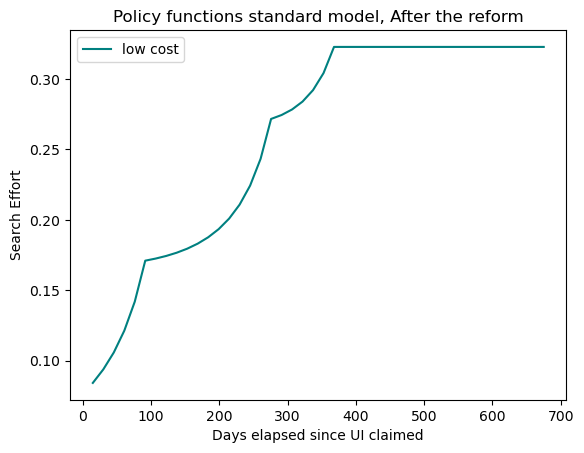

In [246]:
search_effort_new = solve_search_effort_HTM(model_new.par)
time = np.linspace(0, model_new.par.T, model_new.par.T)
plt.plot((time+1)*15, search_effort_new[0,:], label = 'low cost', color='teal') 
# plt.plot((time+1)*15, search_effort_new[1,:], label = 'medium cost', color='orange') 
# plt.plot((time+1)*15, search_effort_new[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

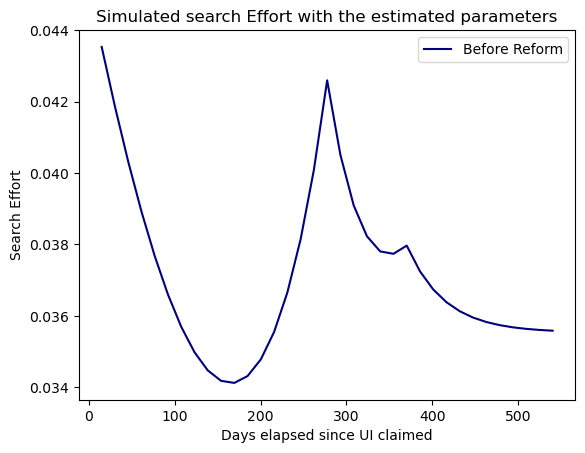

In [247]:
model_new.par.b1 = 222/675*model_new.par.w    # High transfers
model_new.par.b2 = model_new.par.b1    # Medium transfers
model_new.allocate()
sim_new = sim_search_effort_HTM(model_new.par)
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
# plt.ylim(0.0, 0.08)
plt.show()


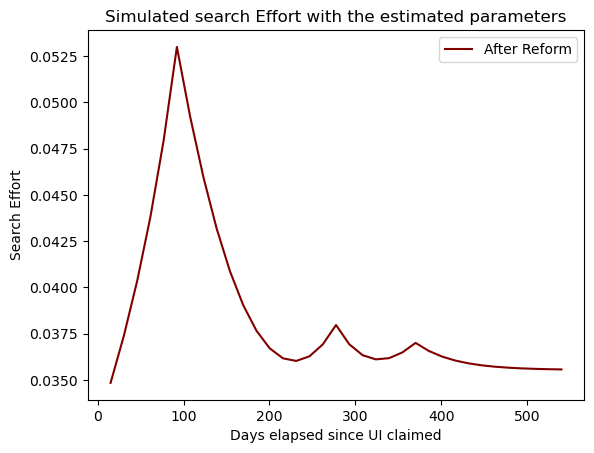

In [248]:
model_new.par.b1 = 342.0/675.0      # Value after reform
model_new.par.b2 = 171.0/675.0      # Value after reform

model_new.allocate()
s_forecast_new = sim_search_effort_HTM(model_new.par)


# Now plotting s_forecast
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, s_forecast_new, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
# plt.ylim(0.0, 0.08)
plt.show()

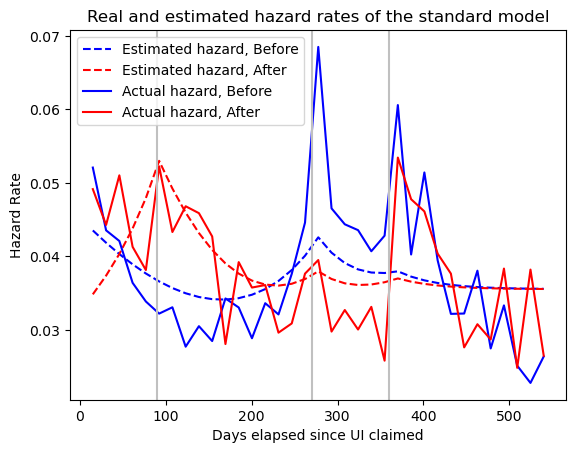

In [249]:
#Replicating figure 7(a) from the paper

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast_new, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
# plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [253]:
true_data_outofsample = model_new.data.moments_after
true_data_insample = model_new.data.moments_before

# Get the mean square errors
mse_eta0_outofsample = np.mean((true_data_outofsample - s_forecast_new)**2)
mse_eta0_insample = np.mean((true_data_insample - sim_new)**2)

# Comparison out of sample
comparison1 = "smaller" if mse_eta1_outofsample < mse_eta0_outofsample else "bigger" if mse_eta1_outofsample > mse_eta0_outofsample else "equal"
comparison2 = "WITH reference dependence" if mse_eta1_outofsample < mse_eta0_outofsample else "WITHOUT reference dependence" 

# Comparison in sample
comparison3 = "smaller" if mse_eta1_insample < mse_eta0_insample else "bigger" if mse_eta1_insample > mse_eta0_insample else "equal"
comparison4 = "WITH reference dependence" if mse_eta1_insample < mse_eta0_insample else "WITHOUT reference dependence"


print("Before the reform: ")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_insample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_insample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison4}\033[0m.")
print("-" * 100)



print("After the reform:")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_outofsample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_outofsample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison2}\033[0m.")
print("-" * 100)

Before the reform: 
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 0.00013702947211844096
The mean square error from the model without reference dependence is 0.00010100473025092892
The mean square error for the model with reference dependence is bigger than the model without.
Best model: WITHOUT reference dependence.
----------------------------------------------------------------------------------------------------
After the reform:
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 9.497331233069367e-05
The mean square error from the model without reference dependence is 8.414922860617118e-05
The mean square error for the model with reference dependence is bigger than the model without.
Best model: WITHOUT reference dependence.
-----------------------

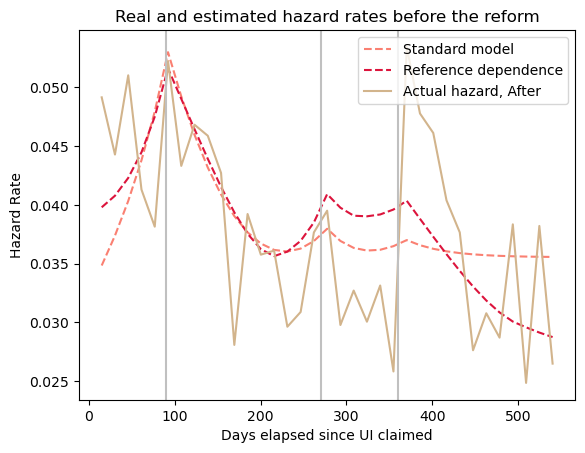

In [254]:
after = model_new.data.moments_after

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, s_forecast_new, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, s_forecast, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()

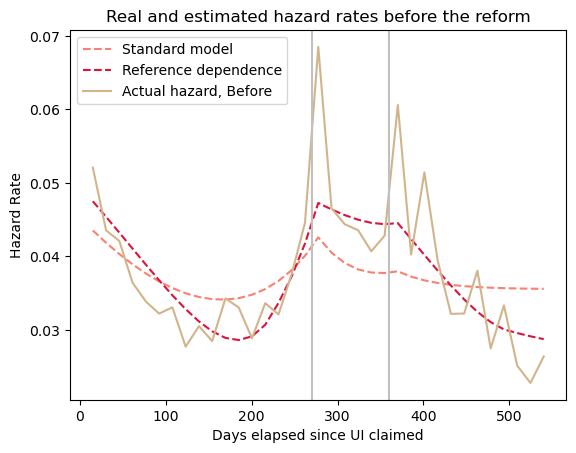

In [255]:
before = model_new.data.moments_before

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, sim_new, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, sim, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()